In [1]:
#1.Библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#2.Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

#3. Метрики
from sklearn.metrics import r2_score as r2, mean_squared_error as mse


# Этапы

1. чтение данных
2. EDA (анализ, визуализация, чтение, просмотр особенностей фичей)
3. обработка выбросов и заполнение пустых значений
4. генерация новых  фичей
5. выбор фичей, участвующих в молели
5. определение модели предсказания (с помощью кросс-валидации)
6. обучение трейна и предсказание на тесте

## 1. Чтение данных

In [2]:
TEST_PATH = '..\\Course_projekt\\test.csv'
TRAIN_PATH = '..\\Course_projekt\\train.csv'

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [3]:
# уменьшаем количество используемой памяти

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

reduce_mem_usage(test_data)
reduce_mem_usage(train_data)

Memory usage of dataframe is 0.67 MB
Memory usage after optimization is: 0.21 MB
Decreased by 67.8%
Memory usage of dataframe is 1.41 MB
Memory usage after optimization is: 0.49 MB
Decreased by 65.5%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


In [4]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [5]:
X_train = train_data.drop('Price', axis=1)
print(X_train.shape)
X_train.head()

(10000, 19)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [6]:
y_train = train_data[['Price']]
y_train.head()

,Price
0,184966.937500
1,300009.437500
2,220925.906250
3,175616.234375
4,150226.531250


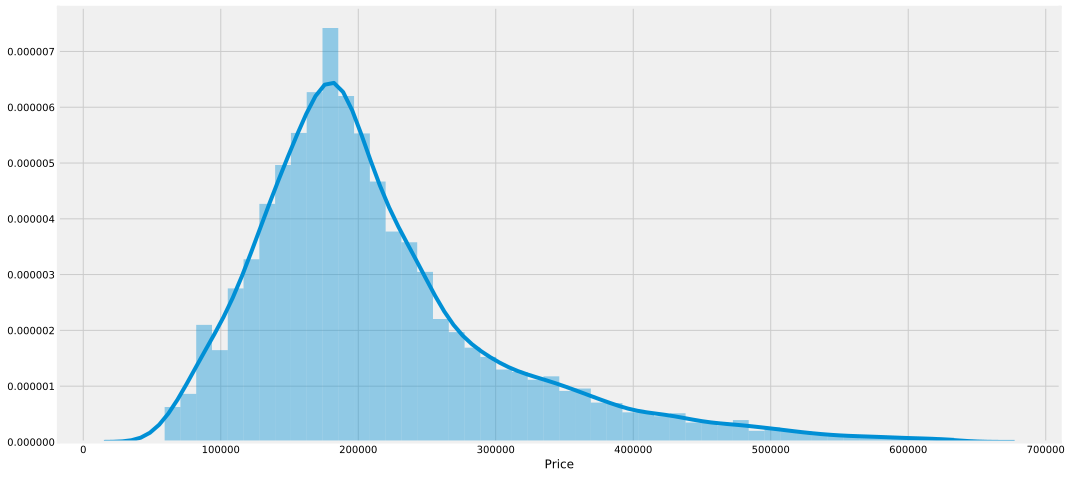

In [7]:
plt.figure(figsize = (16, 8))

sns.distplot(train_data['Price'], bins=50)

In [8]:
X_test = test_data
print(X_test.shape)
X_test.head()

(5000, 19)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


## 2. EDA

### Категориальные переменные

DistrictId

In [9]:
X_train['DistrictId'].value_counts().sort_values()

207      1
196      1
117      1
209      1
205      1
      ... 
9      294
6      511
23     565
1      652
27     851
Name: DistrictId, Length: 205, dtype: int64

In [10]:
#переводим номера районов в категорию 

X_train['DistrictId'] = X_train['DistrictId'].astype('category')
X_test['DistrictId'] = X_test['DistrictId'].astype('category')

In [11]:
X_train['DistrictId'].value_counts().sort_values()

209      1
174      1
196      1
207      1
117      1
      ... 
9      294
6      511
23     565
1      652
27     851
Name: DistrictId, Length: 205, dtype: int64

Ecology_2

In [12]:
X_train['Ecology_2'].value_counts().sort_values()

A      97
B    9903
Name: Ecology_2, dtype: int64

In [13]:
#сразу переводим категории в количественные переменные 

X_train['Ecology_2'] = X_train['Ecology_2'].map({'A':0, 'B':1})
X_test['Ecology_2'] = X_test['Ecology_2'].map({'A':0, 'B':1})

Ecology_3

In [14]:
X_train['Ecology_3'].value_counts().sort_values()

A     275
B    9725
Name: Ecology_3, dtype: int64

In [15]:
X_train['Ecology_3'] = X_train['Ecology_3'].map({'A':0, 'B':1})
X_test['Ecology_3'] = X_test['Ecology_3'].map({'A':0, 'B':1})

Shops_2

In [16]:
X_train['Shops_2'].value_counts().sort_values()

A     825
B    9175
Name: Shops_2, dtype: int64

In [17]:
X_train['Shops_2'] = X_train['Shops_2'].map({'A':1, 'B':0})
X_test['Shops_2'] = X_test['Shops_2'].map({'A':1, 'B':0})

In [18]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,0


### Количественные переменные

__Rooms__

In [19]:
X_train['Rooms'].value_counts().sort_values()

19.0       1
6.0        1
10.0       2
0.0        8
5.0       18
4.0      150
3.0     2235
1.0     3705
2.0     3880
Name: Rooms, dtype: int64

Идея: заменить 0, 10, 19

__Square__

In [20]:
X_train['Square'].value_counts().sort_values()

38.704697    1
80.876266    1
63.997875    1
34.998058    1
62.999760    1
            ..
80.794792    2
81.867165    2
37.498161    2
44.482914    2
65.285133    2
Name: Square, Length: 9995, dtype: int64

In [21]:
X_train['Square'].describe()

count    10000.000000
mean        56.315777
std         21.058731
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

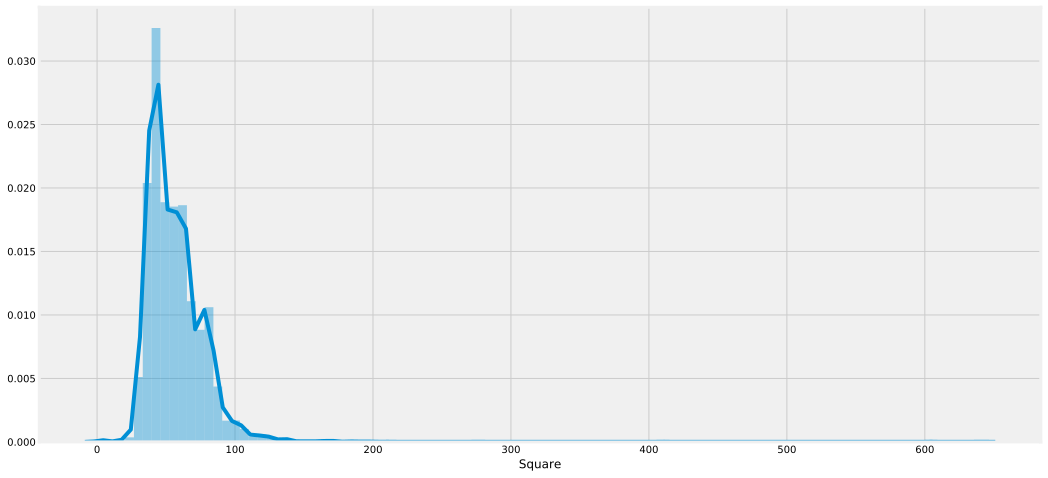

In [22]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Square'], bins=100)

In [23]:
X_train[(X_train['Square'] < 10) | (X_train['Square'] > 300)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
212,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,NaN,3,9,0
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,NaN,0,0,0
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,0
3280,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,NaN,0,1,0
3413,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,0
4262,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,0
4690,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,0
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,NaN,0,0,0
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,NaN,0,1,0
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,1,1,1,264,0,NaN,0,1,0


Идея: убрать слишком малые и слишком большие


__LifeSquare__

In [24]:
X_train['LifeSquare'].value_counts().sort_values()

30.750156    1
45.999352    1
24.499641    1
26.499628    1
32.999142    1
            ..
37.604706    1
32.003857    1
47.015720    1
58.004223    1
33.859653    2
Name: LifeSquare, Length: 7886, dtype: int64

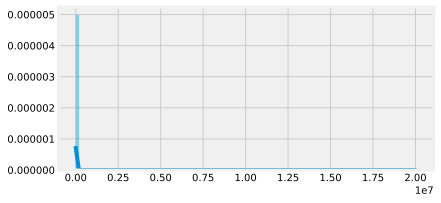

In [25]:
plt.figure(figsize = (6, 3))

sns.distplot(X_train[X_train['LifeSquare'] < 5000], bins=100)

In [26]:
X_train['LifeSquare'].describe()

count    7887.000000
mean       37.199646
std        86.241211
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [27]:
X_train[(X_train['LifeSquare'] < 3) | (X_train['LifeSquare'] > 1000) | (X_train['LifeSquare'] > X_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
26,4378,27,3.0,106.958870,0.641822,0.0,17,0.0,2018,0.072158,1,1,2,629,1,NaN,0,0,1
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,0
44,10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,0
52,2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,1,1,1,264,0,NaN,0,1,0
123,8753,25,3.0,85.952309,89.803749,1.0,4,3.0,2017,0.069753,1,1,53,13670,4,NaN,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,0
9889,12918,23,2.0,51.440464,53.134243,51.0,3,17.0,2017,0.005767,1,1,1,388,0,NaN,0,0,0
9895,2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,1,1,2,469,0,NaN,0,0,0
9902,14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,1,1,37,6856,84,1940.0,2,5,0


Идея: заменить малые и большие значения на средние, поменять на square, где это необходимо 

__KitchenSquare__

In [28]:
X_train['KitchenSquare'].value_counts().sort_values()

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [29]:
X_train[(X_train['KitchenSquare'] > 100)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,1
2969,7441,62,3.0,114.734474,112.589081,112.0,3,3.0,2015,0.072158,1,1,2,629,1,NaN,0,0,1
4651,12552,58,3.0,116.405693,113.109650,112.0,3,3.0,2016,0.437885,1,1,23,5735,3,1084.0,0,5,0
8584,14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,0
9895,2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,1,1,2,469,0,NaN,0,0,0


Идея: заменить выбросы на медианы (меньше 3 или больше 100)

In [30]:
X_train[(X_train['KitchenSquare'] > X_train['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
227,16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,1,1,39,10418,9,900.0,1,9,0
551,1315,6,1.0,48.128113,45.023533,48.0,21,1.0,2013,0.243205,1,1,5,1564,0,540.0,0,0,0
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,NaN,0,0,1
1369,2371,27,2.0,68.841072,64.234955,66.0,4,2.0,2014,0.017647,1,1,2,469,0,NaN,0,0,0
1800,13113,27,1.0,37.805229,2.228592,11.0,6,0.0,2015,0.017647,1,1,2,469,0,NaN,0,0,0
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,1,1,14,3369,24,4129.0,0,3,0
1972,15691,62,1.0,41.735073,12.423181,14.0,3,15.0,2010,0.072158,1,1,2,629,1,NaN,0,0,1
4079,6508,23,2.0,67.146049,33.959152,63.0,5,17.0,2019,0.034656,1,1,0,168,0,NaN,0,0,0
4588,448,48,1.0,41.186905,1.626502,41.0,2,1.0,1977,0.041125,1,1,46,9515,5,NaN,1,10,0
5149,13703,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,0


подумать

__Floor__

In [31]:
X_train['Floor'].value_counts().sort_values()

31      1
33      1
42      1
37      1
32      2
28      3
27      5
26     18
23     25
25     34
24     53
22     54
21     59
20     68
19    121
18    185
1     235
17    256
15    287
16    290
14    362
13    398
12    438
11    457
10    553
2     588
9     604
8     643
7     759
6     802
3     872
5     876
4     949
Name: Floor, dtype: int64

In [32]:
X_train[(X_train['Floor'] > 28)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
339,11563,8,1.0,50.390862,41.642899,0.0,32,32.0,2008,0.092291,1,1,21,4346,2,165.0,1,2,0
2781,1674,76,2.0,74.344673,41.044132,5.0,42,48.0,2016,0.000000,1,1,7,1660,39,1786.0,1,5,0
3330,3298,31,1.0,57.551693,21.551876,10.0,32,40.0,1977,0.151346,1,0,32,5889,10,830.0,4,1,0
4323,6589,30,1.0,62.110825,52.812126,4.0,31,44.0,2009,0.000078,1,1,22,6398,141,1046.0,3,23,0
6755,8296,146,1.0,86.386757,71.904999,0.0,37,38.0,2012,0.236108,1,1,16,3893,27,NaN,3,10,0
8357,8016,31,1.0,59.519897,24.050533,10.0,33,40.0,1977,0.151346,1,0,32,5889,10,830.0,4,1,0


подумать (можно ли вообще дропнуть) или это нормальные значения??

__HouseFloor__

In [33]:
X_train['HouseFloor'].value_counts().sort_values()

47.0        1
117.0       1
29.0        1
31.0        1
45.0        1
44.0        1
36.0        1
26.0        1
38.0        1
48.0        2
39.0        2
99.0        2
28.0        3
32.0        4
37.0        4
27.0        6
40.0        7
30.0       21
13.0       27
11.0       28
21.0       33
23.0       40
2.0        48
6.0        58
7.0        59
18.0       89
20.0      105
19.0      108
15.0      123
3.0       127
4.0       134
10.0      135
8.0       141
24.0      176
0.0       269
22.0      343
25.0      374
1.0       497
16.0      576
14.0      625
5.0      1031
12.0     1074
9.0      1389
17.0     2331
Name: HouseFloor, dtype: int64

In [34]:
X_train[X_train['HouseFloor'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6131,10806,5,1.0,51.944588,48.709602,1.0,6,99.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,0
8599,9300,74,2.0,71.747871,74.579811,9.0,5,99.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,0
8854,78,30,2.0,65.773750,66.811790,1.0,8,117.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,0


обработать

In [35]:
X_train[(X_train['HouseFloor'] < X_train['Floor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
7,11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,0
14,10953,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,1,1,2,629,1,NaN,0,0,1
16,2119,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,NaN,0,0,0
21,11935,27,2.0,64.711838,NaN,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,0
23,6641,54,3.0,118.907608,NaN,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,1,1,34,7065,1,750.0,2,5,0
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,0
9989,4145,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,1,1,53,14892,4,NaN,1,4,0
9991,11553,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,1,1,37,5288,0,1937.0,3,2,0


приравнять к этажу

__HouseYear__

In [36]:
X_train['HouseYear'].value_counts().sort_values()

20052011       1
4968           1
1914           1
1928           1
1916           1
            ... 
2014         210
2015         299
2016         305
2017         308
1977        2652
Name: HouseYear, Length: 97, dtype: int64

обработать 2 выброса, подумать над категориезацией

__Ecology_1__

In [37]:
X_train['Ecology_1'].value_counts().sort_values()

0.012522      1
0.014334      1
0.394094      2
0.011320      3
0.386772      6
           ... 
0.075779    346
0.072158    486
0.243205    511
0.000000    537
0.007122    587
Name: Ecology_1, Length: 129, dtype: int64

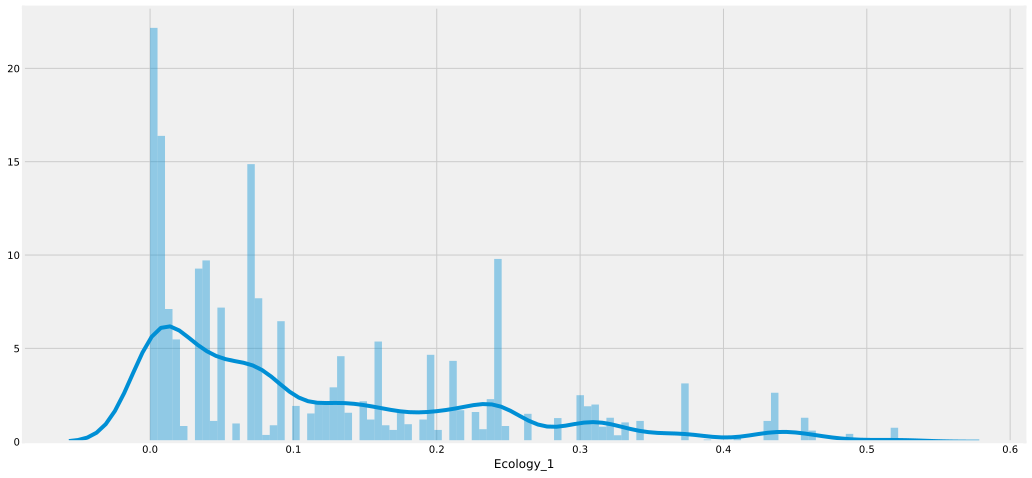

In [38]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Ecology_1'], bins=100)

In [39]:
X_train['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

__Social_1__

In [40]:
X_train['Social_1'].value_counts().sort_values()

3       9
7      15
12     18
13     22
10     24
14     46
20     50
15     51
8      62
38     64
29     70
50     79
41     83
32     87
18     92
49     95
17     96
66     99
19    118
16    123
26    127
42    129
11    138
4     141
28    144
27    151
39    159
74    176
47    177
35    200
0     201
52    201
24    205
37    205
21    207
36    209
9     213
43    238
31    243
46    245
33    252
34    311
53    355
22    367
6     377
23    434
30    465
5     528
25    557
1     654
2     688
Name: Social_1, dtype: int64

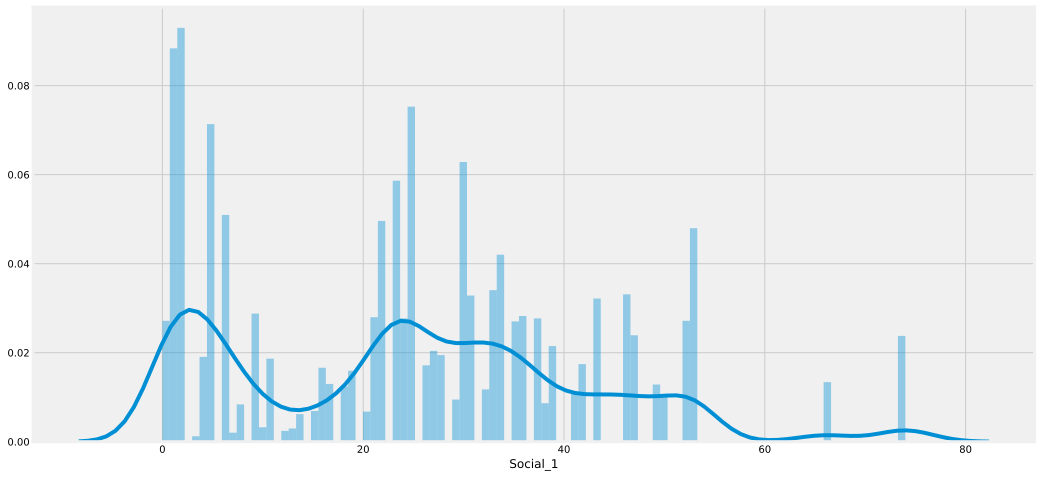

In [41]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Social_1'], bins=100)

__Social_2__

In [42]:
X_train['Social_2'].value_counts().sort_values()

528       1
507       1
662       2
1423      3
568       3
       ... 
6398    245
1437    346
629     486
1564    511
264     587
Name: Social_2, Length: 142, dtype: int64

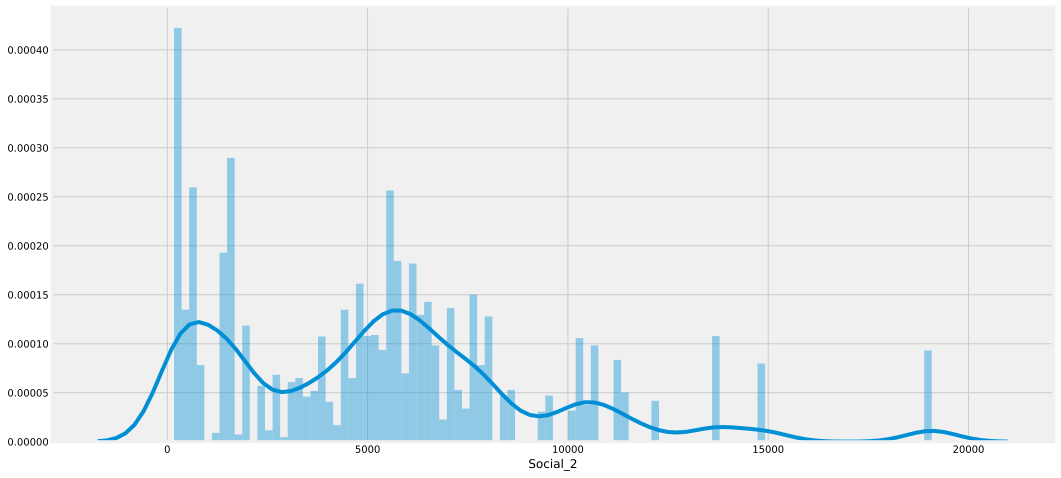

In [43]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Social_2'], bins=100)

__Social_3__

In [44]:
X_train['Social_3'].value_counts().sort_values()

37        3
45        9
73       10
39       15
23       18
20       19
19       22
93       25
59       25
87       27
24       37
84       43
56       49
48       58
27       59
14       97
16      101
10      142
8       170
11      172
7       184
9       192
141     245
5       391
6       423
2       635
4       835
3      1136
1      1861
0      2997
Name: Social_3, dtype: int64

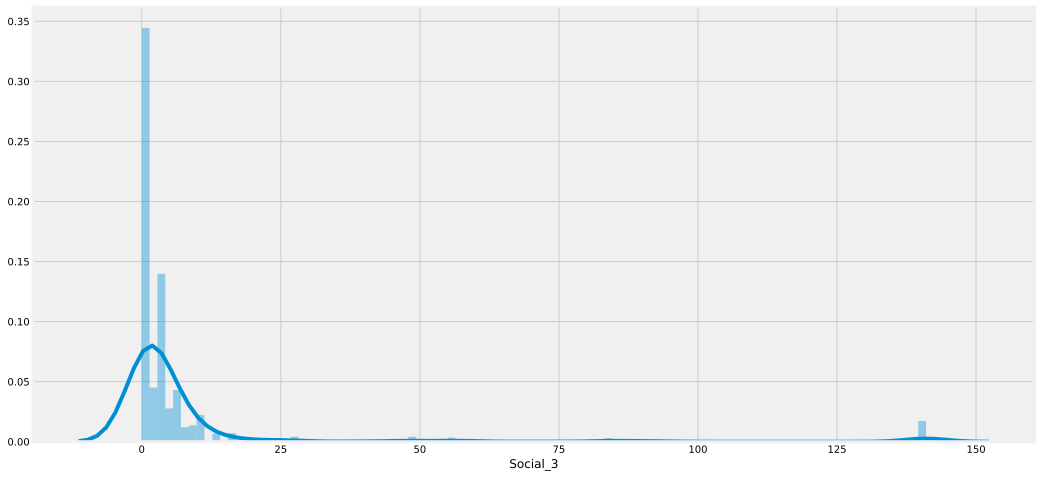

In [45]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Social_3'], bins=100)

__Healthcare_1__

In [46]:
X_train['Healthcare_1'].value_counts().sort_values()

0.0         1
35.0        2
1815.0     10
32.0       12
370.0      14
         ... 
229.0     148
750.0     163
1046.0    245
30.0      348
540.0     511
Name: Healthcare_1, Length: 79, dtype: int64

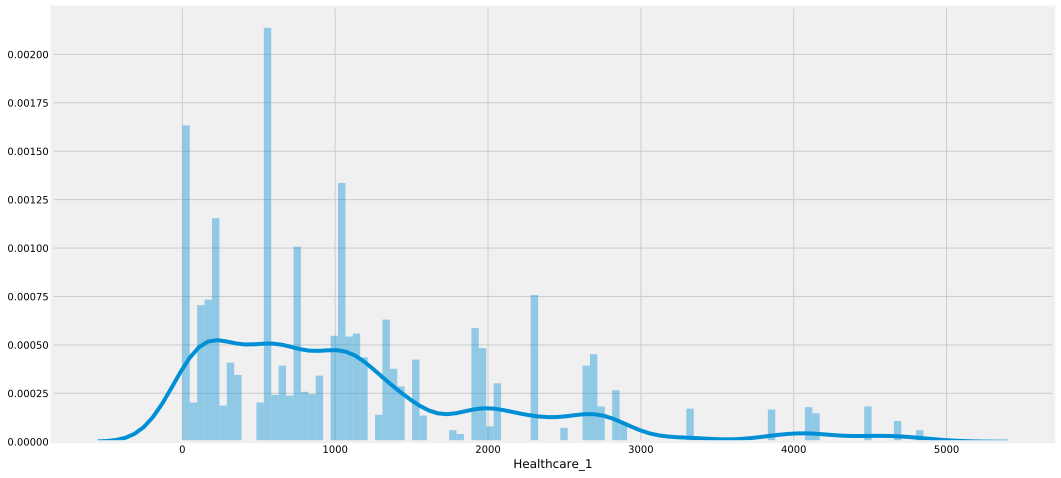

In [47]:
plt.figure(figsize = (16, 8))

sns.distplot(X_train['Healthcare_1'], bins=100)

__Helthcare_2__

In [48]:
X_train['Helthcare_2'].value_counts().sort_values()

6      99
4     288
5     388
2    1158
3    1670
1    2183
0    4214
Name: Helthcare_2, dtype: int64

__Shops_1__

In [49]:
X_train['Shops_1'].value_counts().sort_values()

19      49
16      83
15     176
10     215
23     245
8      253
7      294
9      316
11     401
6      487
3      711
4      841
2      964
5     1324
1     1325
0     2316
Name: Shops_1, dtype: int64

## 3. Обработка выбросов и заполнение пустых значений

In [50]:
X_train.isna().sum() 

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

LifeSquare - заполняем, Healthcare_1 - удаляем

In [51]:
#! DistrictId - идентификационный номер района - включать в выборку не планируем 

In [52]:
# Rooms - меняем выбросы на моду
X_train.loc[(X_train['Rooms'] == 0) | (X_train['Rooms'] > 9), 'Rooms'] = X_train['Rooms'].mode()[0]
X_test.loc[(X_test['Rooms'] == 0) | (X_test['Rooms'] > 9), 'Rooms'] = X_test['Rooms'].mode()[0] #! берем тестовую моду

In [53]:
# Square - меняем слишком большие и слишком малые (подобраны эмпирически) на медиану (более устойчива к имеющимся выбросам)
X_train.loc[(X_train['Square'] < 10) | (X_train['Square'] > 300), 'Square'] = X_train['Square'].median()
X_test.loc[(X_test['Square'] < 10) | (X_test['Square'] > 300), 'Square'] = X_test['Square'].median()

In [54]:
# LifeSquare - заполняем пропуски и убираем нелогичность (жилая площадь должна быть меньше общей площади), 
# заполняем выбросы медианой
def LifeSquare_reloading(X):
    condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())        
    X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

    X.loc[X['LifeSquare'] < 3, 'LifeSquare'] = X['LifeSquare'].median()

    condition_2 = (X['LifeSquare'] > X['Square']) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
    X.loc[condition_2, 'LifeSquare'] = X.loc[condition_2, 'Square']
    
    return X
      
LifeSquare_reloading(X_train)
LifeSquare_reloading(X_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,0
1,15856,74,2.0,69.263184,65.263184,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,0
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,NaN,1,1,0
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,1,1,1,264,0,NaN,0,1,0
4997,5783,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,NaN,5,15,0
4998,4780,62,2.0,81.305222,78.305222,0.0,4,0.0,1977,0.072158,1,1,2,629,1,NaN,0,0,1


In [55]:
# KitchenSquare - убираем нелогичность (площадь кухни должна быть меньше жилой площади) 
def KitchenSquare_solution(X):
    
    condition_3 = (X['KitchenSquare'] > X['LifeSquare'])
    kitchen_life =  X['KitchenSquare'] / X['LifeSquare']
    kitchen_life_mean = kitchen_life.mean() # считаем среднюю долю площади кухни в общей жилой площади
    X.loc[condition_3, 'KitchenSquare'] = X.loc[condition_3, 'LifeSquare'] * kitchen_life_mean
    
    return X

KitchenSquare_solution(X_train)
KitchenSquare_solution(X_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,0
1,15856,74,2.0,69.263184,65.263184,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,0
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,NaN,1,1,0
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,1,1,1,264,0,NaN,0,1,0
4997,5783,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,NaN,5,15,0
4998,4780,62,2.0,81.305222,78.305222,0.0,4,0.0,1977,0.072158,1,1,2,629,1,NaN,0,0,1


In [56]:
# Floor не трогаем - явных выбросов нет 

In [57]:
# HouseFloor - убираем выбросы и нелогичность (количесвто этажей в доме не может быть меньше этажа квартиры)

X_train.loc[X_train['HouseFloor'] < X_train['Floor'], 'HouseFloor'] = X_train['Floor']
X_test.loc[X_test['HouseFloor'] < X_test['Floor'], 'HouseFloor'] = X_test['Floor']

In [58]:
# HouseYear - убираем выбросы (год постройки не больше текущего) 
import datetime
current_year = now = datetime.datetime.now().year

X_train.loc[X_train['HouseYear'] > current_year, 'HouseYear'] = current_year
X_test.loc[X_test['HouseYear'] > current_year, 'HouseYear'] = current_year

In [59]:
#Ecology_1
#Ecology_2 
#Ecology_3 

In [60]:
#Social_1
#Social_2
#Social_3

In [61]:
# Healthcare_1 - убираем из наблюдений (много незаполненных данных)
if 'Healthcare_1' in X_train.columns:
            X_train.drop('Healthcare_1', axis=1, inplace=True)
if 'Healthcare_1' in X_test.columns:
            X_test.drop('Healthcare_1', axis=1, inplace=True)

In [62]:
# Helthcare_2

In [63]:
#Shops_1
#Shops_2

In [64]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0,11,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,1,16,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,0,5,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2,4,0


## 4. Генерация новых фичей

In [65]:
# Средняя цена дома по району
fd_d = train_data.groupby(['DistrictId'])['Price'].mean().reset_index()
fd_d

,DistrictId,Price
0,0,195295.593750
1,1,187805.406250
2,2,243688.625000
3,3,179905.015625
4,4,300096.687500
...,...,...
200,202,394150.875000
201,205,220501.562500
202,207,426186.406250
203,208,431137.625000


In [66]:
X_train = pd.merge(X_train, fd_d, on='DistrictId', how='left')
X_test = pd.merge(X_test, fd_d, on='DistrictId', how='left')

In [67]:
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,0,0,0,162287.312500
1,15856,74,2.0,69.263184,65.263184,1.0,6,6.0,1977,0.075779,1,1,6,1437,3,0,2,0,210696.109375
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,5,5,0,471966.750000
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,3,3,0,213625.765625
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,0,0,1,156046.421875


In [68]:
X_test.fillna(method='pad', inplace=True)

In [69]:
def dis_count(X):
    district = X['DistrictId'].value_counts()
    district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
    X['DistrictId_count'] = X['DistrictId'].map(dict(district))  # self.DistrictId_counts = {'id': value}
        
    X['new_district'] = 0
    X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
    X['DistrictId_count'].fillna(5, inplace=True)
    
    return X
    
dis_count(X_train)
dis_count(X_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,new_district
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,1,11,2748,1,0,0,0,162287.312500,91.0,0
1,15856,74,2.0,69.263184,65.263184,1.0,6,6.0,1977,0.075779,...,1,6,1437,3,0,2,0,210696.109375,61.0,0
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,...,1,30,7538,87,5,5,0,471966.750000,5.0,1
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,1,23,4583,3,3,3,0,213625.765625,5.0,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,2,629,1,0,0,1,156046.421875,391.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,...,1,36,5992,0,1,1,0,204294.812500,5.0,1
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,...,1,1,264,0,0,1,0,187805.406250,344.0,0
4997,5783,12,3.0,77.842178,48.282623,9.0,23,23.0,1989,0.090799,...,1,74,19083,2,5,15,0,218026.750000,5.0,1
4998,4780,62,2.0,81.305222,78.305222,0.0,4,4.0,1977,0.072158,...,1,2,629,1,0,0,1,172723.859375,122.0,0


In [70]:
# Категории по году дома
def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
year_to_cat(X_train)
year_to_cat(X_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,new_district,year_cat
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,11,2748,1,0,0,0,162287.312500,91.0,0,3.0
1,15856,74,2.0,69.263184,65.263184,1.0,6,6.0,1977,0.075779,...,6,1437,3,0,2,0,210696.109375,61.0,0,3.0
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,...,30,7538,87,5,5,0,471966.750000,5.0,1,1.0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,3,3,0,213625.765625,5.0,1,5.0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,0,0,1,156046.421875,391.0,0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,...,36,5992,0,1,1,0,204294.812500,5.0,1,3.0
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,...,1,264,0,0,1,0,187805.406250,344.0,0,6.0
4997,5783,12,3.0,77.842178,48.282623,9.0,23,23.0,1989,0.090799,...,74,19083,2,5,15,0,218026.750000,5.0,1,4.0
4998,4780,62,2.0,81.305222,78.305222,0.0,4,4.0,1977,0.072158,...,2,629,1,0,0,1,172723.859375,122.0,0,3.0


In [71]:
# Категории по этажности
def house_floor_to_cat(X):
        
        X['hfloor_cat'] = 0
        
        X.loc[X['HouseFloor'] < 3, 'hfloor_cat'] = 1
            
        return X
house_floor_to_cat(X_train)
house_floor_to_cat(X_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,new_district,year_cat,hfloor_cat
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,2748,1,0,0,0,162287.312500,91.0,0,3.0,0
1,15856,74,2.0,69.263184,65.263184,1.0,6,6.0,1977,0.075779,...,1437,3,0,2,0,210696.109375,61.0,0,3.0,0
2,5480,190,1.0,13.597818,13.597818,12.0,2,5.0,1909,0.000000,...,7538,87,5,5,0,471966.750000,5.0,1,1.0,0
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,3,3,0,213625.765625,5.0,1,5.0,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,0,0,1,156046.421875,391.0,0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,...,5992,0,1,1,0,204294.812500,5.0,1,3.0,0
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,...,264,0,0,1,0,187805.406250,344.0,0,6.0,0
4997,5783,12,3.0,77.842178,48.282623,9.0,23,23.0,1989,0.090799,...,19083,2,5,15,0,218026.750000,5.0,1,4.0,0
4998,4780,62,2.0,81.305222,78.305222,0.0,4,4.0,1977,0.072158,...,629,1,0,0,1,172723.859375,122.0,0,3.0,0


In [72]:
 #KitchenSquare
    
X_train['KitchenToLifeSquare'] = X_train['KitchenSquare'] / X_train['LifeSquare']
X_test['KitchenToLifeSquare'] = X_test['KitchenSquare'] / X_test['LifeSquare']

## 5. Выбор фичей

In [73]:
X_train.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'DistrictId_count', 'new_district',
       'year_cat', 'hfloor_cat', 'KitchenToLifeSquare'],
      dtype='object')

In [74]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'DistrictId_count', 'new_district',
       'year_cat', 'hfloor_cat', 'KitchenToLifeSquare']

X_train = X_train[remain_features]
X_test = X_test[remain_features]

## 6. Определение модели предсказания

In [75]:
lr_model = LinearRegression()

cv_score = cross_val_score(lr_model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=9))
print(cv_score)
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[0.67005316 0.69188939 0.69654955 0.66817955 0.66963408]
R2: 0.679 +- 0.012


In [76]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=20, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)

cv_score = cross_val_score(dt_model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
print(cv_score)
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[0.67636839 0.69466634 0.70269872 0.70361336 0.73340835]
R2: 0.702 +- 0.018


In [77]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=18, # глубина дерева  
                                 #min_samples_leaf=20, # минимальное кол-во наблюдений в листе дерева
                                 random_state=100,
                                 max_features=7,
                                 n_estimators=100 #кол-во деревьев
                                )

cv_score = cross_val_score(rf_model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=100))
print(cv_score)
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

c:\users\игорь\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\игорь\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\игорь\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\игорь\appdata\local\progr

[0.75910177 0.74810941 0.7569873  0.76245668 0.76010259]
R2: 0.757 +- 0.005


In [78]:
# подбор параметров модели

'''parameters = {
    'n_estimators': [150],
    #'max_features': np.arange(7, 11),
    'max_depth': np.arange(15, 25),
    #'min_samples_leaf': np.arange(5, 10)
}

clf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

clf.fit(X_train, y_train)

clf.best_params_'''

"parameters = {\n    'n_estimators': [150],\n    #'max_features': np.arange(7, 11),\n    'max_depth': np.arange(15, 25),\n    #'min_samples_leaf': np.arange(5, 10)\n}\n\nclf = GridSearchCV(\n    estimator=RandomForestRegressor(),\n    param_grid=parameters,\n    scoring='r2',\n    cv=5,\n)\n\nclf.fit(X_train, y_train)\n\nclf.best_params_"

## 7. Oбучение трейна и предсказание на тесте

In [79]:
rf_model.fit(X_train, y_train)

y_pred_final = rf_model.predict(X_test)

c:\users\игорь\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


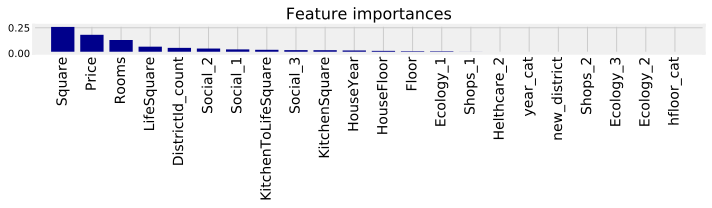

In [80]:
#вес фичей 

def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (10, 3))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = rf_model.feature_importances_, X=X_train)

In [81]:
#запись файла для загрузки

"""import time
preds_final = pd.DataFrame()
#X_test.reset_index(inplace=True)
preds_final['Id'] = test_data['Id'].copy()

preds_final['Price'] = y_pred_final
preds_final.to_csv(f'{time.strftime("%Y%m%d%h%M%S")}_predictions_rf.csv', index=False)

preds_final.head()"""

'import time\npreds_final = pd.DataFrame()\n#X_test.reset_index(inplace=True)\npreds_final[\'Id\'] = test_data[\'Id\'].copy()\n\npreds_final[\'Price\'] = y_pred_final\npreds_final.to_csv(f\'{time.strftime("%Y%m%d%h%M%S")}_predictions_rf.csv\', index=False)\n\npreds_final.head()'

In [82]:
#preds_final.shape